In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits

In [ ]:
#%matplotlib notebook

In [2]:
# Now we need to fit this. Let's first code the model. 
from scipy.special import wofz
def V(x, alpha, gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

def voigt(center,doppler,damp,ll):
    xx = (ll - center)/doppler
    return V(xx,1.0,damp)

In [3]:
def me(S1, S2, eta, vlos, deltav, loga, ll0, ll):
    
    center = ll0 * (1.0 + vlos / 3E5)
    doppler  = deltav/3E5 * ll0
    a = 10.0 ** loga
    profile = voigt(center, doppler, a, ll)
    
    return S1 + S2 / (1.0 + eta * profile)
    
    

In [4]:
def cloud(S, deltatau, vlos, deltav, loga, ll0, ll, I_incoming):
    
    center = ll0 * (1.0 + vlos / 3E5) # line center in Angstroms, shifted due to velocity
    doppler  = deltav/3E5 * ll0 # Doppler width in angstroms
    
    a = 10.0 ** loga
    profile = voigt(center, doppler, a, ll)
    
    tau_lambda = deltatau * profile
    
    return I_incoming * np.exp(-tau_lambda) + S * (1.0 - np.exp(-tau_lambda))
    
    

In [5]:
def model_synth(p, ll0, ll):
    
    
    spectrum_atmos = me(p[0], p[1], p[2], p[3], p[4], p[5], ll0, ll)
    
    spectrum_final = cloud(p[6], p[7], p[8], p[9], p[10] ,ll0, ll, spectrum_atmos)
    
    return spectrum_final

In [17]:
#let's try now scipy.optimize.minimize

def chi2(p, x, y, ll0, error):
    
    #x is ll
    #y are the observed stokes 
    #uncertanties in y
    
    y_model = model_synth(p,ll0, x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return chi2

In [18]:
ll = np.linspace(6560.0, 6565.0, 501)
ll0 = 6562.8

vlos = 5.0 # km/s
deltav = 10. # km/s 
loga = -0.2

S1 = 0.3
S2 = 0.7 
eta = 200

spectrum0 = me(S1, S2, eta, vlos, deltav, loga, ll0, ll)

In [19]:
data = fits.open("/home/milic/data/scratch/mihi_data.fits")[0].data

In [20]:
data.shape

(146, 160, 4, 638)

<Figure size 640x480 with 0 Axes>

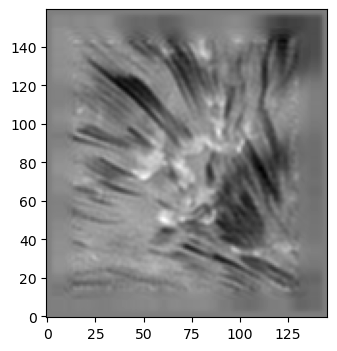

In [21]:
plt.clf()
plt.figure(figsize=[5,4])
plt.imshow(np.sum(data[:,:,0,200:205], axis =2).T, origin='lower', cmap='grey')

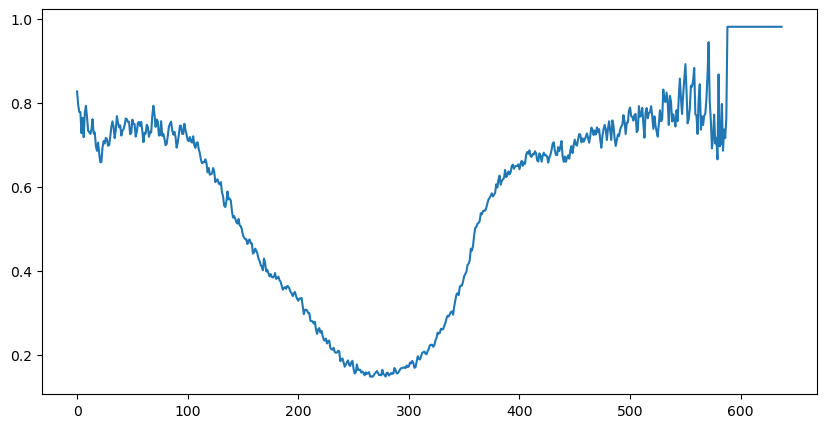

In [22]:
plt.figure(figsize=[10,5])
plt.plot(data[48,119,0,:])

In [23]:
lmin = 45
lmax = 525

In [24]:
ll = fits.open("/home/milic/data/scratch/mihi_data.fits")[1].data[lmin:lmax]


In [25]:
#def me(S1, S2, eta, vlos, deltav, a, ll0, ll):
#def cloud(S, deltatau, vlos, deltav, a, ll0, ll, I_incoming):

params = np.array([0.10, 0.7, 100.0, 0.0, 2.0, -1, 0.1, 10.0, -30.0, 2.0, -4.0])

In [26]:
b=[(0.0,2.0), #S1
        (-2.0,2.0), # S2 
        (80,120.), # eta
        (-5,5), # vlos
        (1.0,20.0), # delta_v
        (-4,1), # log a
        (0, 2.0), # S_cloud
        (0,100), # delta_tau
        (-150, 150), # vlos_cloud
        (1.0, 15.0), # deltav_cloud
        (-4, -1)] # log_a_cloud

In [27]:
# Break the below code in a few steps:
from scipy.optimize import minimize
i = 44
j = 54

spectrum_to_fit = data[i,j,0,lmin:lmax]
result = minimize(chi2,params,args=(ll,spectrum_to_fit,ll0, 1E-4), bounds=b)

print (result.x)

[  0.19531191   0.59478746 120.           2.60848949   9.36095212
  -0.89904057   0.68431785   1.46157074  42.50175151   1.
  -1.36974459]


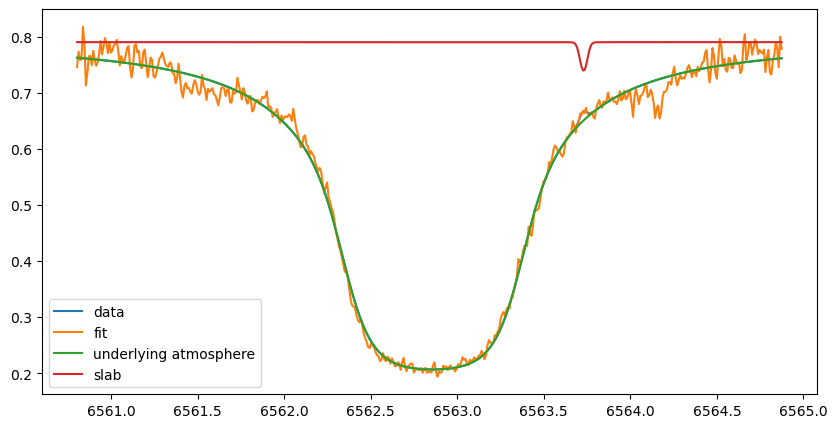

In [29]:
synth = model_synth(result.x, ll0, ll)
atmos_part = me(result.x[0], result.x[1], result.x[2], result.x[3], result.x[4], result.x[5], ll0, ll)
slab_part = cloud(result.x[6], result.x[7], result.x[8], result.x[9], result.x[10], ll0, ll, result.x[0]+result.x[1])
plt.figure(figsize=[10,5])
plt.plot(ll, synth, label='data')
plt.plot(ll,spectrum_to_fit, label = 'fit')
plt.plot(ll, atmos_part, label = 'underlying atmosphere')
plt.plot(ll, slab_part, label = 'slab')

plt.legend()

In [30]:
print(result.x[2])
print(result.x[3], result.x[4])
print(result.x[8], result.x[9])
print(result.x[6], result.x[7])

120.0
2.6084894869895536 9.360952122820205
42.501751509424246 1.0
0.6843178544185852 1.4615707428814135


In [31]:
from tqdm import tqdm

In [ ]:
# Let's try the whole cube:
noise = 1E-4
cube = []

for i in tqdm(range(15, 125)):
    for j in range(15,140):
        
        spectrum_to_fit = data[i,j,0,45:525]
        result = minimize(chi2,params,args=(ll,spectrum_to_fit,ll0, noise), bounds=b)
        
        cube.append(result)
        
        

In [ ]:
result = np.asarray(result)

In [ ]:
cube.shape

In [ ]:
cube1 = np.asarray(cube)

In [ ]:
cube[0].x

In [ ]:
len(cube)

In [ ]:
model = np.zeros([13750, 11])

In [ ]:
for i in range (0,13750):
    model[i,:] = cube[i].x

In [ ]:
model.shape

In [ ]:
model = model.reshape(110,125,11)

In [ ]:
%matplotlib qt4
def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

In [ ]:
plt.figure(figsize=[6,8])
plt.subplot(321)
plt.title('Slab optical depth')
plt.imshow(model[:,:,7].T, origin='lower', cmap='Grays', vmin=0,vmax=20)
plt.colorbar()
plt.subplot(322)
plt.title('Intensity at xx')
plt.imshow(np.sum(data[:,:,0,200:205], axis =2).T, origin='lower', cmap='grey')
plt.colorbar()
plt.subplot(323)
plt.title('Slab Source Function')
plt.imshow(model[:,:,6].T, origin='lower', cmap='Grays', vmin=0,vmax=1)
plt.colorbar()
plt.subplot(324)
plt.title('Slab LOS')
plt.imshow(model[:,:,8].T, origin='lower', cmap='bwr', vmin=-20,vmax=20)
plt.colorbar()
plt.subplot(325)
plt.title('Atmosphere LOS')
plt.imshow(model[:,:,3].T, origin='lower', cmap='bwr', vmin=-3,vmax=3)
plt.colorbar()
plt.subplot(326)
plt.title('Slab optical depth')
plt.imshow(model[:,:,7].T, origin='lower', cmap='Grays', vmin=0,vmax=20)
plt.colorbar()
plt.tight_layout()
plt.savefig('inversion.png', bbox_inches='tight')


In [ ]:
plt.figure(figsize=[6,2.7])
plt.subplot(121)
plt.title('Slab optical depth')
plt.imshow(model[:,:,7].T, origin='lower', cmap='Grays', vmin=0,vmax=20)
plt.colorbar()
plt.subplot(122)
plt.title('Intensity at xx')
plt.imshow(np.sum(data[:,:,0,200:205], axis =2).T, origin='lower', cmap='grey')

In [ ]:
i = 80
j = 66

vsl = (ll-6562.8) / 6562.8 * 3E5

synth = model_synth(model[i,j,:], ll0, ll)
atmos_part = me(model[i,j][0], model[i,j][1], model[i,j][2], model[i,j][3], model[i,j][4], model[i,j][5], ll0, ll)
slab_part = cloud(model[i,j][6], model[i,j][7], model[i,j][8], model[i,j][9], model[i,j][10], ll0, ll, model[i,j][0]+model[i,j][1])
plt.figure(figsize=[10,5])
plt.plot(vsl, synth, label='data')
plt.plot(vsl, data[i+15,j+15,0,lmin:lmax])
plt.plot(vsl, atmos_part, label = 'underlying atmosphere')
plt.plot(vsl, slab_part, label = 'slab')

plt.legend()

In [ ]:
model[i,j]